In [1]:
#import packages
import numpy as np
from numpy import loadtxt
import pylab as pl
from IPython import display
from RcTorchPrivate import *
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import time

#this method will ensure that the notebook can use multiprocessing (train multiple 
#RC's in parallel) on jupyterhub or any other linux based system.
try:
    mp.set_start_method("spawn")
except:
    pass
torch.set_default_tensor_type(torch.FloatTensor)
%matplotlib inline
start_time = time.time()

## Rc and systems of ODEs: an overview

In this notebook we demonstrate that the RC can solve systems of differential equations. Any higher order ODE can be decomposed into a system of first order ODEs, hence solving systems of ODEs means that RC can solver higher order ODEs. This is a standard procedure followed by standard integrators . To apply the RC to systems, the RC architecture needs to be modified to return multiple outputs $N_j$, where $j$ indicates a different output. Specifically, the number of the outputs needs to be the same as the number of the equations in a system. Each output has a different set of weights $W_{out}^{(j)}$ while all the $N_j$ share the same hidden states.

We exploit the RC solver in solving the equations of motion for a nonlinear Hamiltonian system, the nonlinear oscillator.  The energy is conserved in this system and thus, we adopt hamiltonian energy regularization that drastically accelerates the training and improves the fidelity of the predicted solutions. 

### Hamiltonian systems
Hamiltonian systems  obey the energy conservation law. In other words, these systems are characterized by a hamiltonian function that represents the total energy of the system which remains constant in time. The hamiltonian of a nonlinear oscillator with unity mass and frequency is given by:
\begin{align}
    \label{eq:NL_ham}
    \mathcal{H} = \frac{p^2}{2} + \frac{x^2}{2} + \frac{x^4}{4},
\end{align}
and the associated equations of motion reads:
\begin{align}
    \label{eq:NL_x} 
    \dot x &= p \\
    \label{eq:NL_p}
    \dot p &= -x - x^3
\end{align}
where $p$ is the momentum and $x$ represents the position of the system. The loss function consists of three parts: $L_\text{ODE}$ for the ODEs of x and p; a hamiltonian penalty $L_{\mathcal{H}}$ that penalizes violations in the energy conservation and is defined by Eq

Subsequently, the total $L$  reads:
\begin{align}
    L &= L_\text{ODE}+ L_{\mathcal{H}} + L_\text{reg} \nonumber \\
     \label{eq:NL_loss}
     &= \sum_{n=0}^{K}
      \Big[ \left(\dot x_n-p_n\right)^2 + \left(\dot p_n + x_n + x_n^3  \right)^2 +\left(E - \mathcal{H}(x_n, p_n)\right)^2 \Big]   + \lambda \sum_{j=x,p} W_{out}^{(j)T} W_{out}^{(j)}.
\end{align}

In [2]:
def f(u, t ,lam=0,A=0,W=1):
            x,  px = u      # unpack current values of u
            derivs = [px, -x - lam*x**3 +A*np.sin(W*t)]     # you write the derivative here
            return derivs
        
# Scipy Solver   
def NLosc_solution(t, x0,  px0, lam=0, A=0,W=1):
    u0 = [x0, px0]
    # Call the ODE solver
    solPend = odeint(f, u0, t.cpu(), args=(lam,A,W,))
    xP = solPend[:,0];        pxP = solPend[:,1];   
    return xP, pxP

def plot_results(RC, results, integrator_model, y0s, ax = None):
    """plots a RC prediction and integrator model prediction for comparison
    Parameters
    ----------
    RC: RcTorchPrivate.esn
        the RcTorch echostate network to evaluate. This model should already have been fit.
    results: dictionary
        the dictionary of results returned by the RC after fitting
    integrator model: function
        the model to be passed to odeint which is a gold standard integrator numerical method
        for solving ODE's written in Fortran. You may find the documentation here:
        https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html
    ax: matplotlib.axes._subplots.AxesSubplot
        If provided, the function will plot on this subplot axes
    """
    X = RC.X.cpu().detach()
    #int_sols = []
    if not ax:
        fig, ax = plt.subplots(1,1, figsize = (6,6))
    
    for i, y in enumerate(results["ys"]):
        y = y.cpu().detach()
        if not i:
            labels = ["RC","integrator"]
        else:
            labels = [None, None, None, None]
        try:
            labels
        except:
            pass
        
        ax.plot(y[:,0], y[:,1], label = labels[0], 
                linewidth =7, alpha = 0.9, color = "blue")
        
        
        #calculate the integrator prediction:
        y_truth, p_truth  = NLosc_solution(RC.X.squeeze().data,y0s[i],1,lam=1, A=0, W= 0) 
        
        #p = y[:,1].cpu()# + v0
        #yy = y[:,0].cpu()# + y0
        
        #plot the integrator prediction
        ax.plot(y_truth, p_truth, color = "red", linewidth =3, 
                alpha = 1.0, label = labels[1])
#         ax.plot(X, p, color = "red", alpha = 1.0, linewidth =3, 
#                 label = labels[3])
        
    ax.set_xlabel("x")
    ax.set_ylabel("p")
    ax.set_ylim(-3,3)
    ax.set_xlim(-3,3)
    ax.legend();
    #return int_sols

def force(X, A = 0):
    return torch.zeros_like(X)

def plot_rmsr(RC, results, force, log = False, ax = None):
    """plots the residuals of a RC prediction directly from the loss function
    Parameters
    ----------
    RC: RcTorchPrivate.esn
        the RcTorch echostate network to evaluate. This model should already have been fit.
    results: dictionary
        the dictionary of results returned by the RC after fitting
    force: function
        the force function describing the force term in the population equation
    ax: matplotlib.axes._subplots.AxesSubplot
        If provided, the function will plot on this subplot axes
    """
    if not ax:
        fig, ax = plt.subplots(1,1, figsize = (10, 4))
    X = RC.X.cpu().detach()
    ys, ydots = results["ys"], results["ydots"]
    
    residuals = []
    for i, y in enumerate(ys):
        y = y.cpu().detach()
        ydot = ydots[i].cpu().detach()
        resids = custom_loss(X, y, ydot, None, 
                             force = force, 
                             ode_coefs = RC.ode_coefs,
                             mean = False,
                            init_conds = RC.init_conds,
                            ham = False)
        rmsr = torch.sqrt(resids)
        if not i:
            rmsr_tensor = rmsr
            label = "individual trajectory rmsr"
        else:
            rmsr_tensor = torch.cat((rmsr_tensor, rmsr), axis = 1)
            label = None
        
        if log:
            rmsr = torch.log10(rmsr)
            
        ax.plot(X, rmsr, color = "red", alpha = 0.4, label = label)
    
    mean_rmsr = torch.mean(rmsr_tensor, axis =1)
    ax.plot(X, torch.log10(mean_rmsr), 
                color = "blue", 
                alpha = 0.9, 
                label = "mean rmr")

    ax.legend();
    
    ax.set_xlabel("time")
    if log:
        ax.set_ylabel("log rmsr")
        
    else:
        ax.set_ylabel("root mean square error")
        
#     plot_data = {"time": X, 
#                  "ys" : ys,
#                  "ydots" : ydots,
#                  "resids" : residuals,
#                  "mean_resid": mean_resid}
#     return plot_data

def driven_force(X, A = 1):
    return A * torch.sin(X)

def no_force(X, A = 0):
    return A

#define a reparameterization function, empirically we find that g= 1-e^(-t) works well)
def reparam(t, order = 1):
    
    exp_t = torch.exp(-t)
    derivatives_of_g = []
    
    g = 1 - exp_t
    g_dot = 1 - g
    return g, g_dot
    
    #first derivative
    
    
    #example code for higher derivatives:
    #####################################
    
    #derivatives_of_g.append(g_dot)
    #derivatives_of_g.append(g)
#     for i in range(order):
#         if i %2 == 0:
#             #print("even")
#             derivatives_of_g.append(g_dot)
#         else:
#             #print("odd")
#             derivatives_of_g.append(-g_dot)
#    return derivatives_of_g


def custom_loss(X, y, ydot, out_weights, force = force, 
                reg = False, ode_coefs = None, mean = True,
               enet_strength = None, enet_alpha = None, init_conds = None, lam = 1, ham = True):
    y, p = y[:,0].view(-1,1), y[:,1].view(-1,1)
    ydot, pdot = ydot[:,0].view(-1,1), ydot[:,1].view(-1,1)
    
    #with paramization
    L =  (ydot - p)**2 + (pdot + y + lam * y**3   - force(X))**2
    
    if mean:
        L = torch.mean(L)
    
    if reg:
        #assert False
        weight_size_sq = torch.mean(torch.square(out_weights))
        weight_size_L1 = torch.mean(torch.abs(out_weights))
        L_reg = enet_strength*(enet_alpha * weight_size_sq + (1- enet_alpha) * weight_size_L1)
        L = L + 0.1 * L_reg 
    if ham:
        y0, p0 = init_conds
        ham = hamiltonian(y, p)
        ham0 = hamiltonian(y0, p0)
        L_H = (( ham - ham0).pow(2)).mean()
        assert L_H >0

        L = L +  0.1 * L_H
    
    #print("L1", hi, "L_elastic", L_reg, "L_H", L_H)
    return L



In [3]:
def optimize_last_layer(esn, 
                        SAVE_AFTER_EPOCHS = 1,
                        epochs = 45000,
                        custom_loss = custom_loss,
                        loss_threshold = 10**-10,#10 ** -8,
                        f = force,
                        lr = 0.05, 
                        reg = None,
                        plott = False,
                        plot_every_n_epochs = 2000):#gamma 0.1, spikethreshold 0.07 works
    
    with torch.enable_grad():
        #define new_x
        new_X = esn.extended_states.detach()
        spikethreshold = esn.spikethreshold

        #force detach states_dot
        esn.states_dot = esn.states_dot.detach().requires_grad_(False)

        #define criterion
        criterion = torch.nn.MSELoss()

        #assert esn.LinOut.weight.requires_grad and esn.LinOut.bias.requires_grad
        #assert not new_X.requires_grad

        #define previous_loss (could be used to do a convergence stop)
        previous_loss = 0

        #define best score so that we can save the best weights
        best_score = 0

        #define the optimizer
        optimizer = optim.Adam(esn.parameters(), lr = lr)

        #optimizer = torch.optim.SGD(model.parameters(), lr=100)
        if esn.gamma_cyclic:
            cyclic_scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 10**-6, 0.01,
                                              gamma = esn.gamma_cyclic,#0.9999,
                                              mode = "exp_range", cycle_momentum = False)

        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=esn.gamma)
        lrs = []

        #define the loss history
        loss_history = []

        if plott:
            #use pl for live plotting
            fig, ax = pl.subplots(1,3, figsize = (16,4))

        t = esn.X#.view(*N.shape).detach()
        g, g_dot = esn.G
        y0  = esn.init_conds[0]

        floss_last = 0


        try:
            assert esn.LinOut.weight.requires_grad and esn.LinOut.bias.requires_grad
        except:
            esn.LinOut.weight.requires_grad_(True)
            esn.LinOut.bias.requires_grad_(True)

        #begin optimization loop
        for e in range(epochs):

            optimizer.zero_grad()

            N = esn.forward( esn.extended_states )
            N_dot = esn.calc_Ndot(esn.states_dot)

            y = g *N 

            ydot = g_dot * N + g * N_dot

            y[:,0] = y[:,0] + esn.init_conds[0]
            y[:,1] = y[:,1] + esn.init_conds[1]

            assert N.shape == N_dot.shape, f'{N.shape} != {N_dot.shape}'

            loss = custom_loss(esn.X, y, ydot, esn.LinOut.weight, reg = reg, ode_coefs = esn.ode_coefs,
                              init_conds = esn.init_conds, enet_alpha= esn.enet_alpha, enet_strength = esn.enet_strength)
            loss.backward()
            optimizer.step()
            if esn.gamma_cyclic and e > 0 and e <5000:
                cyclic_scheduler.step()
            lrs.append(optimizer.param_groups[0]["lr"])


            floss = float(loss)
            
            if e > 0:
                loss_delta = float(np.log(floss_last) - np.log(floss)) 
                if loss_delta > esn.spikethreshold:# or loss_delta < -3:
                    lrs.append(optimizer.param_groups[0]["lr"])
                    scheduler.step()
            
            if not e and not best_score:
                best_bias, best_weight, best_fit = esn.LinOut.bias.detach(), esn.LinOut.weight.detach(), y.clone()

            if e > SAVE_AFTER_EPOCHS:
                if not best_score:
                    best_score = min(loss_history)
                best_bias, best_weight = esn.LinOut.bias.detach(), esn.LinOut.weight.detach()
                best_score = float(loss)
                best_fit = y.clone()
                best_pred = y.clone()
                best_ydot = ydot.clone()
            
            loss_history.append(floss)
            floss_last = floss
            if plott and e:

                if e % plot_every_n_epochs == 0:
                    for param_group in optimizer.param_groups:
                        print('lr', param_group['lr'])
                    ax[0].clear()
                    logloss_str = 'Log(L) ' + '%.2E' % Decimal((loss).item())
                    delta_loss  = ' delta Log(L) ' + '%.2E' % Decimal((loss-previous_loss).item())

                    print(logloss_str + ", " + delta_loss)
                    ax[0].plot(y.detach().cpu(), label = "exact")
                    ax[0].set_title(f"Epoch {e}" + ", " + logloss_str)
                    ax[0].set_xlabel("t")

                    ax[1].set_title(delta_loss)
                    ax[1].plot(N_dot.detach().cpu())
                    #ax[0].plot(y_dot.detach(), label = "dy_dx")
                    ax[2].clear()
                    #weight_size = str(weight_size_sq.detach().item())
                    #ax[2].set_title("loss history \n and "+ weight_size)

                    ax[2].loglog(loss_history)
                    ax[2].set_xlabel("t")

                    [ax[i].legend() for i in range(3)]
                    previous_loss = loss.item()

                    #clear the plot outputt and then re-plot
                    display.clear_output(wait=True) 
                    display.display(pl.gcf())


        return {"weights": best_weight, 
                "bias" : best_bias, 
                "loss" : {"loss_history" : loss_history},
                "ydot" : best_ydot, 
                "y" : best_pred,
                "best_score" : best_score}



In [4]:
def force(X, A = 0):
    return torch.zeros_like(X)
lam =1
def hamiltonian(x, p, lam = lam):
    return (1/2)*(x**2 + p**2) + lam*x**4/4

In [5]:
BURN_IN = 1000
x0,xf, nsteps = 0, 5, 1000
xtrain = torch.linspace(x0, xf, steps = nsteps, requires_grad=False)

#the length of xtrain won't matter above. Only dt , x0, and xf matter for ODEs.
#the reason for this is that the input time vector is reconstructed internally in rctorch
#in order to satisfy the specified dt.
xtrain = torch.linspace(x0, xf, steps = nsteps, requires_grad=False).view(-1,1)

In [6]:
nl_oscillator_hp_set = {'dt': 0.001,
 'regularization': 48.97788193684461,
 'n_nodes': 500,
 'connectivity': 0.017714821964432213,
 'spectral_radius': 2.3660330772399902,
 'leaking_rate': 0.0024312976747751236,
 'bias': 0.37677669525146484,
 'enet_alpha': 0.2082211971282959,
 'enet_strength': 0.118459548397668,
 'spikethreshold': 0.43705281615257263,
 'gamma': 0.09469877928495407,
 'gamma_cyclic': 0.999860422666841}

In [7]:
base = 2*np.pi#10*np.pi
x0, xf= 0, base
nsteps = int(abs(xf - x0)/(nl_oscillator_hp_set["dt"]))
xtrain = torch.linspace(x0, xf, nsteps, requires_grad=False).view(-1,1)
float(xtrain[1]- xtrain[0])

0.0010001887567341328

In [8]:
%%time
y0s = np.arange(0.7, 1.8, 0.2)
v0 = 1

RC = EchoStateNetwork(**nl_oscillator_hp_set, 
                       random_state = 209, 
                       feedback = False, 
                       id_ = 10,
                       activation_f = torch.sin,
                       act_f_prime = torch.cos,
                       dtype = torch.float32, n_outputs = 2)

train_args = {"burn_in" : int(BURN_IN), 
              "ODE_order" : 1,
              "force" : force,
              "reparam_f" : reparam,
              "init_conditions" : [y0s, float(v0)],
              "ode_coefs" :       [1, 1],
              "X" :   xtrain.view(-1, 1),
              "eq_system" : True,
              #"out_weights" : out_weights
              }
#fit
results = RC.fit(**train_args, 
                 SOLVE = True,
                 train_score = True,
                 backprop_f = optimize_last_layer, 
                 epochs = 10000,
                 ODE_criterion = custom_loss)

CPU times: user 7min 26s, sys: 52.5 s, total: 8min 18s
Wall time: 7min 22s


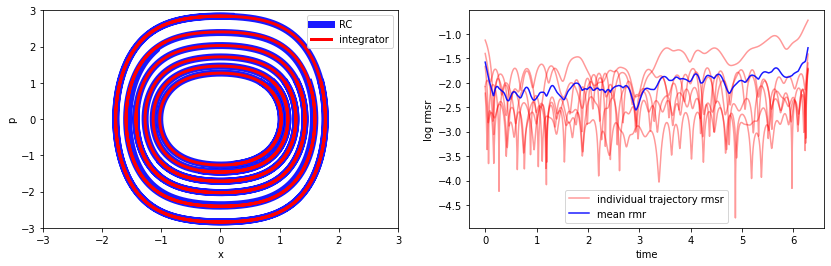

In [9]:
fig, ax = plt.subplots(1,2,figsize = (14,4))
plot_results(RC, results, NLosc_solution, y0s, ax = ax[0])
plot_data = plot_rmsr(RC,
                      results, 
                      force = no_force, 
                      log = True, 
                      ax = ax[1])

In [10]:
end_time = time.time()
print(f'Total notebook runtime: {end_time - start_time:.2f} seconds')

Total notebook runtime: 444.32 seconds
